In [51]:
cd '/content/drive/MyDrive/All/MS/DM/Notebooks/Assignments'

/content/drive/MyDrive/All/MS/DM/Notebooks/Assignments


# TRAINING A CLASSIFIER on CIFER10 dataset


## Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [52]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


### 1. Loading and normalizing CIFAR10

In [53]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


let's see some of the training images

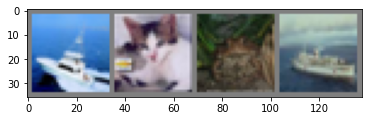

 ship   cat  frog  ship


In [54]:
# function to show an image
def imshow(img):
  img = img / 2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' %classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network

In [55]:
# Define a Neural Network for 3 channel images 
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [56]:
net = Net()

### 3. Define a Loss function and optimizer

In [57]:
# Define a Loss Function and Optimizer

# Lets use a Classification Cross-Entropy loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [58]:
# Train the network 
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data

    # wrap then in a variable
    # inputs, labels = Varaiable(inputs), Variable(labels)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print("Finished Training")


[1,  2000] loss: 2.237
[1,  4000] loss: 1.910
[1,  6000] loss: 1.717
[1,  8000] loss: 1.621
[1, 10000] loss: 1.546
[1, 12000] loss: 1.489
[2,  2000] loss: 1.432
[2,  4000] loss: 1.413
[2,  6000] loss: 1.390
[2,  8000] loss: 1.360
[2, 10000] loss: 1.344
[2, 12000] loss: 1.325
Finished Training


In [59]:
# lets save our trained model
PATH = './cifer_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data

we have trained the network, now let's check if it has learnt anything

we will predict this by predicting the class label

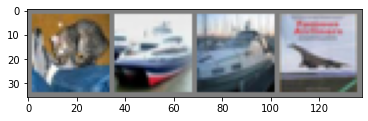

GroundTruth:    cat  ship  ship plane


In [60]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' %classes[labels[j]] for j in range(4)))

In [61]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [62]:
outputs = net(images)

In [63]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' %classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


Lets see how the network performs on the whole dataset

In [64]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d%%' %(100*correct / total))

Accuracy of the network on the 10000 test images: 54%


let's see what are the classes performed well

In [65]:
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 73 %
Accuracy of  bird : 22 %
Accuracy of   cat : 50 %
Accuracy of  deer : 46 %
Accuracy of   dog : 48 %
Accuracy of  frog : 57 %
Accuracy of horse : 63 %
Accuracy of  ship : 59 %
Accuracy of truck : 56 %


How to run on GPU

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [67]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [68]:
inputs, labels = data[0].to(device), data[1].to(device)